<a href="https://colab.research.google.com/github/tigerak/1st_practice/blob/main/AI_03_%ED%97%88%EC%98%81%EB%B2%94_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install xgboost
    !pip install catboost
    !pip install eli5
    !pip install shap
    !pip install pdpbox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, plot_confusion_matrix, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, classification_report

from category_encoders import OrdinalEncoder, TargetEncoder

from tensorflow.keras.utils import to_categorical

import eli5
from eli5.sklearn import PermutationImportance

import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# 신용카드 사용자 연체 예측 모델

고객의 신용 등급을 알맞게 평가하는 것은 금융사업을 하는데에 매우 중요한 일입니다. 
하지만 신용이라는 것은 상당히 주관적인 판단이기 때문에 
단지 한 두 가지의 특성만으로는 정의 내리기 매우 곤란한 부분이기도 합니다.
때문에 다양한 항목들을 이용하여 종합적인 판단을 하여야하는데
그 많은 항목들을 사람이 판단하기는 너무 많은 경험이 필요하며
신규 고객의 경우 쌓여있는 데이터가 없기 때문에 
잘못된 판단을 내릴 수 있는 확률이 매우 높아집니다.

이에 기존 고객들의 정보를 활용하여  '연체 위험도 자동 분류 모델'을 만들었습니다.

모델은 '다중 분류' 모델로
위험 등급은 0, 1, 2등급으로 나누어집니다.
위험도가 높을 수록 높은 등급을 받게 될 것입니다.

In [ ]:
### 데이터 불러오기

df = pd.read_csv('/content/train.csv')

In [ ]:
### 데이터 탐색

# 결측치 탐색

df.isna().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
# 형태 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


신용카드는 5년마다 갱신되기에 이 데이터세트에는 카드를 갱신한 동일인의 기록이 여러개 남아있다.
모든 특성을 합친 값이 동일한 사람은 동일인으로 간주하여 하나의 ‘개인 식별 코드(ID)’를 부여했다.

나이와  근로 기간은 일 단위로 기록되어있어 이를 년 단위로 바꾸고 나머지 절삭하였다.

직업 유형 특성의 약 1/3이 결측되어있으나 사용하지 않을 수 없는 특성이기 때문에 
다른 모든 특성을 이용하여 결측치 예측 모델을 만들어 처리하였다 

데이터 누수는 발생하지 않았다.

In [ ]:
### 형식별 이상치 탐색

nums = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'begin_month', 
       'child_num', 'email', 'family_size', 'income_total', 'phone', 'work_phone']
       
cats= ['car', 'edu_type', 'family_type', 'gender', 'house_type', 
       'income_type', 'occyp_type', 'reality']

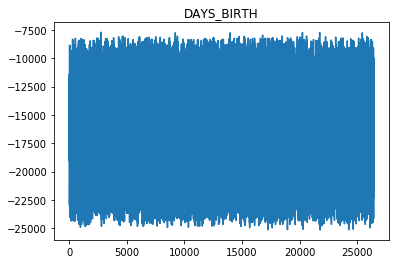

0보다 큰 샘플 수 : 0
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 26457


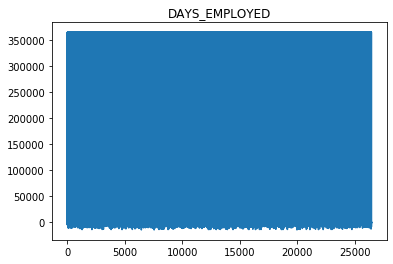

0보다 큰 샘플 수 : 4438
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 22019


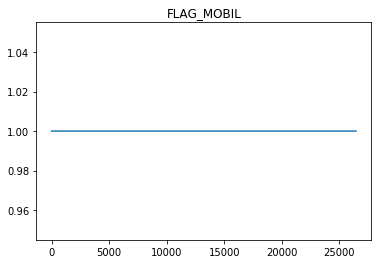

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


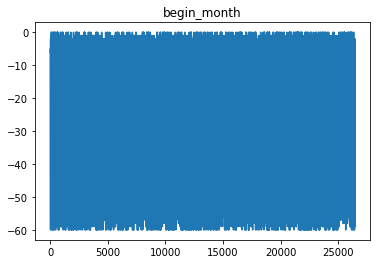

0보다 큰 샘플 수 : 0
0과 같은 샘플 수 : 231
0보다 작은 샘플 수: 26226


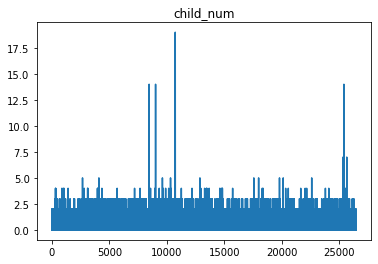

0보다 큰 샘플 수 : 8117
0과 같은 샘플 수 : 18340
0보다 작은 샘플 수: 0


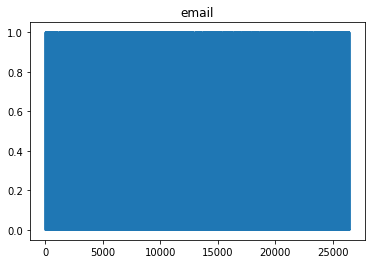

0보다 큰 샘플 수 : 2415
0과 같은 샘플 수 : 24042
0보다 작은 샘플 수: 0


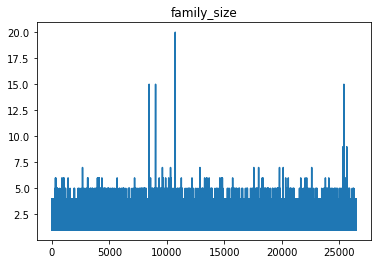

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


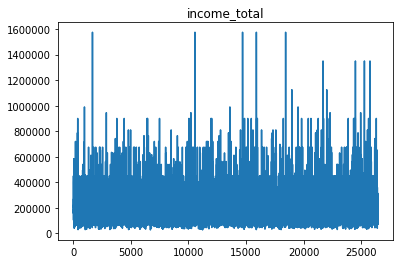

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


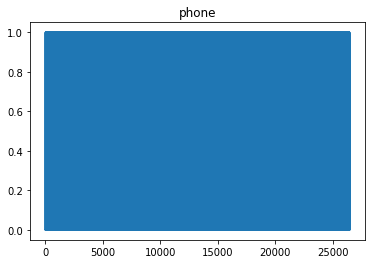

0보다 큰 샘플 수 : 7785
0과 같은 샘플 수 : 18672
0보다 작은 샘플 수: 0


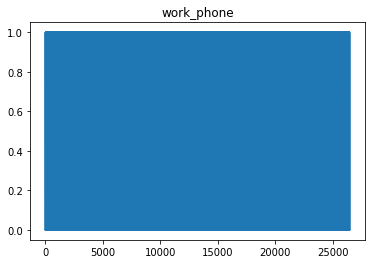

0보다 큰 샘플 수 : 5946
0과 같은 샘플 수 : 20511
0보다 작은 샘플 수: 0


In [ ]:
# 수치형 데이터 이상치 탐색

for i in nums:
    df[i].plot()
    plt.title(i)
    plt.show()
    print('0보다 큰 샘플 수 :', len(df[df[i] > 0]))
    print('0과 같은 샘플 수 :', len(df[df[i] == 0]))
    print('0보다 작은 샘플 수:', len(df[df[i] < 0]))

In [ ]:
df['child_num'].value_counts().sort_index()

0     18340
1      5386
2      2362
3       306
4        47
5        10
7         2
14        3
19        1
Name: child_num, dtype: int64

In [ ]:
df['family_size'].value_counts().sort_index()

1.0      5109
2.0     14106
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
9.0         2
15.0        3
20.0        1
Name: family_size, dtype: int64

In [ ]:
# 수치형 데이터 이상치 보정

df.loc[df['child_num'] >= 5, 'child_num'] = 5
df.loc[df['family_size'] >= 7, 'family_size'] = 7
df.loc[df['income_total'] >= 1000000, 'income_total'] = 1000000

In [ ]:
# DAYS_EMPLOYED의 양수 값은 고용되지 않은 상태를 의미함.

df.loc[df['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

In [ ]:
# 부호 이상치 음 양 변환

def neg (i):
    return i * -1

In [ ]:
cols = ['DAYS_EMPLOYED', 'begin_month', 'DAYS_BIRTH', 'income_total']
for col in cols :
    for i in range(len(df[col])):
        if df[col][i] < 0 :
            df[col][i] = neg(df[col][i])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
for col in cols :
    for i in range(len(df[col])):
        if df[col][i] < 0 :
            print(df[col][i])

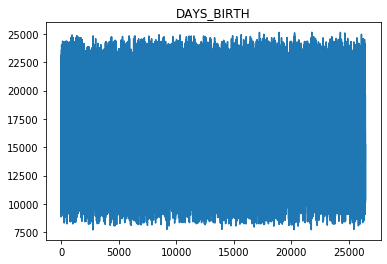

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


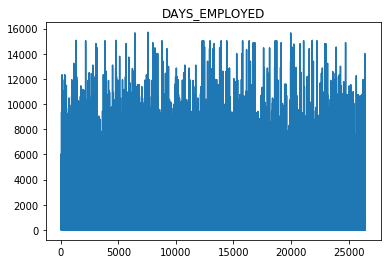

0보다 큰 샘플 수 : 22019
0과 같은 샘플 수 : 4438
0보다 작은 샘플 수: 0


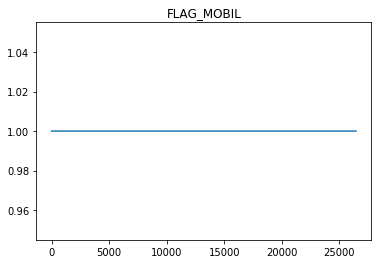

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


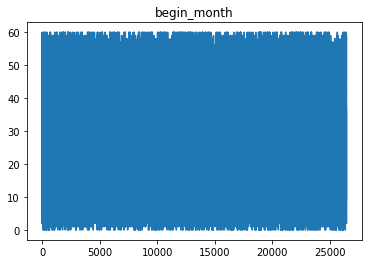

0보다 큰 샘플 수 : 26226
0과 같은 샘플 수 : 231
0보다 작은 샘플 수: 0


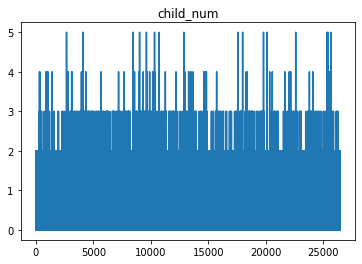

0보다 큰 샘플 수 : 8117
0과 같은 샘플 수 : 18340
0보다 작은 샘플 수: 0


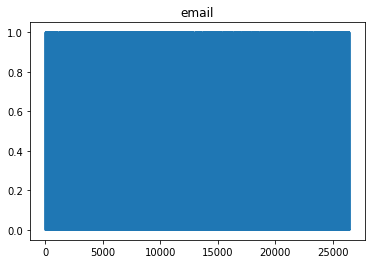

0보다 큰 샘플 수 : 2415
0과 같은 샘플 수 : 24042
0보다 작은 샘플 수: 0


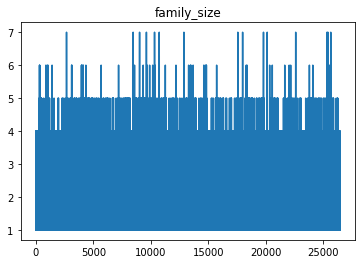

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


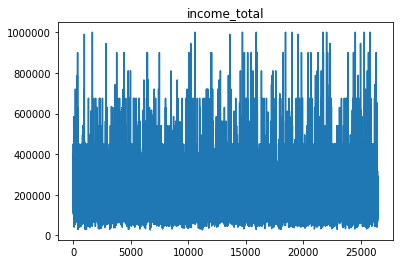

0보다 큰 샘플 수 : 26457
0과 같은 샘플 수 : 0
0보다 작은 샘플 수: 0


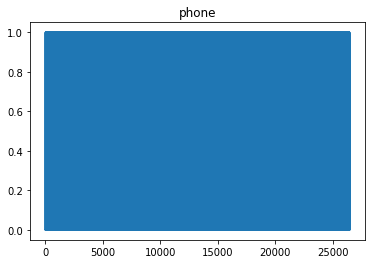

0보다 큰 샘플 수 : 7785
0과 같은 샘플 수 : 18672
0보다 작은 샘플 수: 0


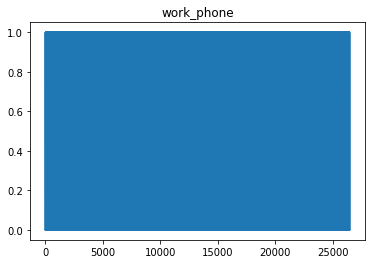

0보다 큰 샘플 수 : 5946
0과 같은 샘플 수 : 20511
0보다 작은 샘플 수: 0


In [ ]:
for i in nums:
    df[i].plot()
    plt.title(i)
    plt.show()
    print('0보다 큰 샘플 수 :', len(df[df[i] > 0]))
    print('0과 같은 샘플 수 :', len(df[df[i] == 0]))
    print('0보다 작은 샘플 수:', len(df[df[i] < 0]))

In [ ]:
df.duplicated().sum()

0

In [ ]:
# 범주형 데이터 이상치 탐색

for i in cats :
    print(i, df[i].unique(),'\n')

car ['N' 'Y'] 

edu_type ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree'] 

family_type ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow'] 

gender ['F' 'M'] 

house_type ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment'] 

income_type ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student'] 

occyp_type [nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff'] 

reality ['N' 'Y'] 



In [ ]:
# 동일인 파악

df['ID'] = (df['gender'].astype(str) + df['car'].astype(str) 
            + df['reality'].astype(str) + df['child_num'].astype(str) 
            + df['income_type'].astype(str) + df['edu_type'].astype(str) 
            + df['family_type'].astype(str) + df['house_type'].astype(str)
            + df['DAYS_BIRTH'].astype(str) + df['DAYS_EMPLOYED'].astype(str)
            + df['income_total'].astype(str) + df['family_size'].astype(str)
            + df['occyp_type'].astype(str))

In [ ]:
df['ID'].duplicated().sum()

17701

In [ ]:
len(df['ID'].unique())

8756

In [ ]:
# ID 숫자화

df['ID'] = OrdinalEncoder().fit_transform(df['ID'])

In [ ]:
# 나이, 근속년 추가

df['age'] = df['DAYS_BIRTH'] // 365
df['years_EMPLOYED'] = df['DAYS_EMPLOYED'] // 365


In [ ]:
df['income_total'] = df['income_total'] / 100000

In [ ]:
# 결측치 처리 - CatBoost 예측값으로 처리

df['occyp_type'] = df['occyp_type'].fillna(0)

In [ ]:
idx = []
for i in df.index:
    if df['occyp_type'][i] == 0:
        idx.append(i)

In [ ]:
test = df.iloc[idx]
train = df.drop(test.index)

In [ ]:
train.shape, test.shape

((18286, 23), (8171, 23))

In [ ]:
X_train = train[train.columns.difference(['index', 'occyp_type'])]
y_train = train[['occyp_type']]

X_test = test[train.columns.difference(['index', 'occyp_type'])]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.18,
                                                    random_state=2)

print(X_train.shape, X_val.shape, '\n',
      y_train.shape, y_val.shape, '\n',
      df.shape)

(14994, 21) (3292, 21) 
 (14994, 1) (3292, 1) 
 (26457, 23)


0:	learn: 2.7518276	test: 2.7290908	best: 2.7290908 (0)	total: 255ms	remaining: 13m 36s
100:	learn: 1.0001521	test: 1.0188034	best: 1.0188034 (100)	total: 14.3s	remaining: 7m 18s
200:	learn: 0.7183087	test: 0.8279450	best: 0.8279450 (200)	total: 27s	remaining: 6m 43s
300:	learn: 0.5498545	test: 0.7211634	best: 0.7211634 (300)	total: 39.3s	remaining: 6m 18s
400:	learn: 0.4398795	test: 0.6564442	best: 0.6564442 (400)	total: 51.6s	remaining: 6m
500:	learn: 0.3590204	test: 0.6146152	best: 0.6146152 (500)	total: 1m 4s	remaining: 5m 44s
600:	learn: 0.2956957	test: 0.5819624	best: 0.5819624 (600)	total: 1m 16s	remaining: 5m 32s
700:	learn: 0.2461261	test: 0.5584181	best: 0.5584181 (700)	total: 1m 29s	remaining: 5m 19s
800:	learn: 0.2091230	test: 0.5416687	best: 0.5416687 (800)	total: 1m 42s	remaining: 5m 5s
900:	learn: 0.1782864	test: 0.5273006	best: 0.5273006 (900)	total: 1m 54s	remaining: 4m 53s
1000:	learn: 0.1538562	test: 0.5162273	best: 0.5162273 (1000)	total: 2m 7s	remaining: 4m 40s
110

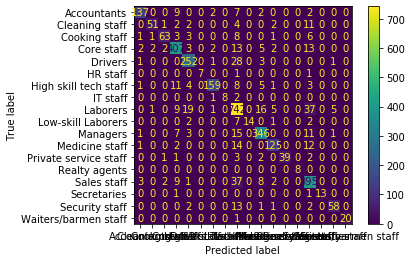

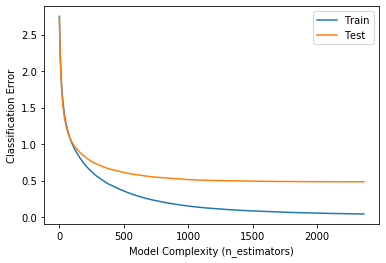

In [ ]:
# 결측치 처리 모델

cat_features = ['edu_type', 'family_type', 'house_type', 'income_type',
                'ID', 'car', 'gender', 'reality']

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features = cat_features)

val_dataset = Pool(data=X_val,
                  label=y_val,
                  cat_features = cat_features)

# 모델 생성
model = CatBoostClassifier(iterations=3200,
                           learning_rate=0.05,
                           max_depth=10,
                           loss_function='MultiClass',
                           early_stopping_rounds = 100,
                           use_best_model = True,
                           verbose=100,
                           task_type='GPU')

model.fit(train_dataset,
          eval_set=val_dataset)

# 모델 평가
preds_class = model.predict(val_dataset)
preds_proba = model.predict_proba(val_dataset)
preds_raw = model.predict(val_dataset, 
                          prediction_type='RawFormulaVal')

print(preds_raw)

print('accuracy :', accuracy_score(y_val, preds_class))
print('f1 score :', f1_score(y_val, preds_class, average='micro'))

plot_confusion_matrix(model, X_val, y_val, values_format='d')
plt.show()

results = model.evals_result_
train_error = results['learn']['MultiClass']
test_error = results['validation']['MultiClass']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend()
plt.show()

model.save_model("missing_value_imputation_model")


In [ ]:
'''
bestTest = 0.33940423
bestIteration = 479
accuracy : 0.8933778857837181
'''

'\nbestTest = 0.33940423\nbestIteration = 479\naccuracy : 0.8933778857837181\n'

In [ ]:
# 결측치 처리 모델 불러오기

from_file = CatBoostClassifier()

model = from_file.load_model("/content/missing_value_imputation_model")

In [ ]:
# X_test_proc = preprocessing.transform(X_test)

preds_class = model.predict(X_test)

In [ ]:
df.loc[idx, 'occyp_type'] = preds_class

In [ ]:
df.isna().sum()

index             0
gender            0
car               0
reality           0
child_num         0
income_total      0
income_type       0
edu_type          0
family_type       0
house_type        0
DAYS_BIRTH        0
DAYS_EMPLOYED     0
FLAG_MOBIL        0
work_phone        0
phone             0
email             0
occyp_type        0
family_size       0
begin_month       0
credit            0
ID                0
age               0
years_EMPLOYED    0
dtype: int64

In [ ]:
df2 = df.copy()

In [ ]:
# 쓸모 없는 특성 계속해서 생산

df2['fwpe'] = df2['FLAG_MOBIL']+df2['work_phone']+df2['phone']+df2['email']
df2['baby'] = df2['age'] - df2['years_EMPLOYED']


In [ ]:
# 로그 스케일

def log_scale(log_df):
    for log_col in cols: 
        log_df[log_col] = np.log1p(1+log_df[log_col])

    return log_df

In [ ]:
# df2 = log_scale(df2)

In [ ]:
# 수치형 데이터 범주화

def make_bin(col, n=10):
    count, bin_dividers = np.histogram(df[col], bins = n)

    cut_categories = pd.cut(df[col], bins = bin_dividers, 
                            include_lowest=True, labels = range(n)
                            )
    bined_array = pd.factorize(cut_categories)[0]
    return bined_array


In [ ]:
'''
n = [8, 6, 10, 10]
for i, col in enumerate(cols):
    df2[col] = make_bin(col, n[i])
'''

'\nn = [8, 6, 10, 10]\nfor i, col in enumerate(cols):\n    df2[col] = make_bin(col, n[i])\n'

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           26457 non-null  int64  
 1   gender          26457 non-null  object 
 2   car             26457 non-null  object 
 3   reality         26457 non-null  object 
 4   child_num       26457 non-null  int64  
 5   income_total    26457 non-null  float64
 6   income_type     26457 non-null  object 
 7   edu_type        26457 non-null  object 
 8   family_type     26457 non-null  object 
 9   house_type      26457 non-null  object 
 10  DAYS_BIRTH      26457 non-null  int64  
 11  DAYS_EMPLOYED   26457 non-null  int64  
 12  FLAG_MOBIL      26457 non-null  int64  
 13  work_phone      26457 non-null  int64  
 14  phone           26457 non-null  int64  
 15  email           26457 non-null  int64  
 16  occyp_type      26457 non-null  object 
 17  family_size     26457 non-null 

## 가설 및 모델 생성

안정된 삶은 사는 사람일 수록 연체 위험도 또한 낮아질 것이라고 판단하였습니다.

그래서 ‘총 수입’이 하위 25% 이상, ‘나이’가 30세 이상, ‘근로 기간’이 3년 이상이며
그리고 ‘가족의 수’가 4인 이하, ‘자녀의 수’가 2인 이하 일 때 
가장 연체 위험도가 낮을 것으로 가정하였습니다.

이를 확인하고자 몇 가지 모델을 만들어 비교하고 
최상의 모델에서 상설한 각각의 특성들을 그래프로 그려 가설을 확인해보겠습니다.

모델의 평가는 Log Loss로 한다.
Log Loss는 단순히 답을 맞추었는지 맞추지 못하였는지로 평가하는 것이 아니라
답을 몇 퍼센트의 확률로 맞추었는지 계산하고 
잘못 예측한 부분에는 패널티를 부여하여 평가하는 지표로써
결과값이 균등하게 분포되지 않은 경우에 알맞는 평가 지표이다.
0에 가까울수록 정확한 모델이 된다.


[[ Data ]]

- 개인 : 식별코드(ID), 나이, 성별, 최종 학력
- 가족 : 가족 수, 자녀 수, 가족형태, 주거 형태
- 직업 : 직업 유형, 근로기간, 총 수입, 수익 형태      
- 자산 : 차량 보유, 부동산 소유
- 기타 : 신용카드 사용 기한(5년 만기)

[[ Target ]]

- 신용 : 연체 위험 등급( 0, 1, 2)

In [ ]:
### 불필요 특성 및 다중 공산성 문제 특성 제거 및 데이터세트 분류

X = df2[df2.columns.difference(['credit', 'index', 'FLAG_MOBIL', 'work_phone', 'phone', 
                                'email', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'fwpe', 'baby'])]

# X = df2[df2.columns.difference(['credit', 'index', 'FLAG_MOBIL'])]
y = df2[['credit']]

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size=0.8, test_size=0.2,
                                                  random_state=2)

print(X_train.shape, X_val.shape, '\n',
      y_train.shape, y_val.shape, '\n',
      df.shape)

(21165, 15) (5292, 15) 
 (21165, 1) (5292, 1) 
 (26457, 23)


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


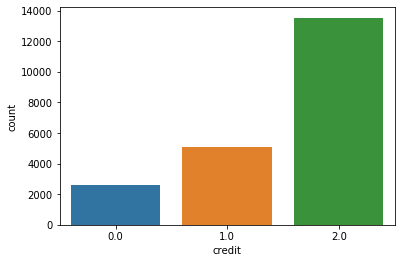

In [ ]:
# Target 분포 확인

sns.countplot(y_train['credit'])

In [ ]:
y_train.value_counts(normalize=True)

credit
2.0       0.639263
1.0       0.238696
0.0       0.122041
dtype: float64

In [ ]:
### 랜덤 포레스트로 기준 모형 생성

pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, criterion='entropy',
                           oob_score = True, random_state=42)
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
y_pred_proba = pipe.predict_proba(X_val)

print('accuracy :', accuracy_score(y_val, y_pred))
print('f1 score :', f1_score(y_val, y_pred, average='micro'))
print('log_loss :', log_loss(to_categorical(y_val['credit']), y_pred_proba))

print(classification_report(y_val, y_pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


accuracy : 0.7063492063492064
f1 score : 0.7063492063492064
log_loss : 0.8672190869947369
              precision    recall  f1-score   support

         0.0       0.43      0.29      0.35       639
         1.0       0.59      0.49      0.54      1215
         2.0       0.77      0.86      0.81      3438

    accuracy                           0.71      5292
   macro avg       0.60      0.55      0.56      5292
weighted avg       0.69      0.71      0.69      5292



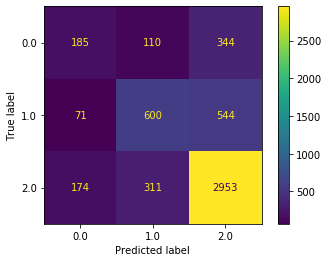

In [ ]:
# 혼동 행렬

plot_confusion_matrix(pipe, X_val, y_val, values_format='d')

In [ ]:
# Cross Value Score

k = 5
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_log_loss')

print(f'Log Loss ({k} folds):', -scores)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
is_categorical is deprecated and will be removed in a fu

Log Loss (5 folds): [0.89290041 0.82643596 0.88006147 0.84273186 0.91982254]


In [ ]:
print(f'{round(-scores.mean(), 3)} (+/-{round(scores.std() / 2, 3)})')

0.872 (+/-0.017)


In [ ]:
### CatBoost ### 
'''
# 전처리

preprocessing = make_pipeline(
                     OrdinalEncoder()
                     )
X_train_proc = preprocessing.fit_transform(X_train)
X_val_proc = preprocessing.transform(X_val)
'''
'''
X_train_proc['begin_month'] = X_train_proc['begin_month'].astype('int64')
X_train_proc['family_size'] = X_train_proc['family_size'].astype('int64')
X_train_proc['income_total'] = X_train_proc['income_total'].astype('int64')

X_val_proc['begin_month'] = X_val_proc['begin_month'].astype('int64')
X_val_proc['family_size'] = X_val_proc['family_size'].astype('int64')
X_val_proc['income_total'] = X_val_proc['income_total'].astype('int64')

cat_features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'ID', 'begin_month', 'car', 'child_num',
                'edu_type', 'email', 'family_size', 'family_type', 'gender',
                'house_type', 'income_total', 'income_type', 'occyp_type', 'phone',
                'reality', 'work_phone']
'''

# 문자형 특성
cat_features = ['ID', 'edu_type', 'family_type', 'house_type', 'income_type',
                'occyp_type', 'car', 'gender', 'reality']

# 데이터를 예쁘게 분리 - 텍스트 특성을 사용
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features = cat_features)

val_dataset = Pool(data=X_val,
                   label=y_val,
                   cat_features = cat_features)

# 모델 생성
model = CatBoostClassifier(iterations=3500,
                           learning_rate=0.01,
                           max_depth=10,
                           loss_function='MultiClass',
                           l2_leaf_reg=0.01,
                           use_best_model = True,
                           early_stopping_rounds = 100,
                           verbose=100,
                           task_type='GPU')

model.fit(train_dataset,
          eval_set=val_dataset,
          plot=True)

# 모델 평가
preds_class = model.predict(val_dataset)
preds_proba = model.predict_proba(val_dataset)
preds_raw = model.predict(val_dataset, 
                          prediction_type='RawFormulaVal')

print(preds_raw)

print('accuracy :', accuracy_score(y_val, preds_class))
print('f1 score :', f1_score(y_val, preds_class, average='micro'))
print('log_loss :', log_loss(to_categorical(y_val['credit']), preds_proba))

print(classification_report(y_val, preds_class))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0929679	test: 1.0925056	best: 1.0925056 (0)	total: 74.1ms	remaining: 4m 19s
100:	learn: 0.7927451	test: 0.7876573	best: 0.7876573 (100)	total: 4.09s	remaining: 2m 17s
200:	learn: 0.7209282	test: 0.7306797	best: 0.7306797 (200)	total: 8.06s	remaining: 2m 12s
300:	learn: 0.6820115	test: 0.7150454	best: 0.7150454 (300)	total: 11.9s	remaining: 2m 6s
400:	learn: 0.6528411	test: 0.7095256	best: 0.7095024 (399)	total: 15.7s	remaining: 2m 1s
500:	learn: 0.6271627	test: 0.7067553	best: 0.7067553 (500)	total: 19.6s	remaining: 1m 57s
600:	learn: 0.6053598	test: 0.7051389	best: 0.7051378 (580)	total: 23.5s	remaining: 1m 53s
700:	learn: 0.5829876	test: 0.7034355	best: 0.7034148 (699)	total: 27.4s	remaining: 1m 49s
800:	learn: 0.5637106	test: 0.7026987	best: 0.7026202 (789)	total: 31.3s	remaining: 1m 45s
900:	learn: 0.5431199	test: 0.7022536	best: 0.7022470 (870)	total: 35.3s	remaining: 1m 41s
1000:	learn: 0.5229737	test: 0.7022895	best: 0.7021712 (970)	total: 39.4s	remaining: 1m 38s
bes

In [ ]:
'''
f1 score : 0.7394179894179895
log_loss : 0.6698602672614506
'''

'\nf1 score : 0.7394179894179895\nlog_loss : 0.6698602672614506\n'

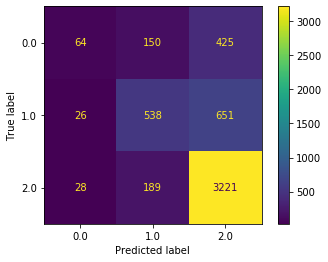

In [ ]:
# 혼동 행렬

plot_confusion_matrix(model, X_val, y_val, values_format='d')

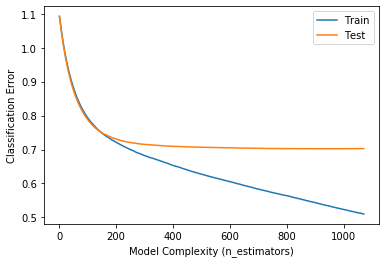

In [ ]:
# 학습 그래프

results = model.evals_result_
train_error = results['learn']['MultiClass']
test_error = results['validation']['MultiClass']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

In [ ]:
row = X_val.iloc[[144]]

explainer = shap.TreeExplainer(model)
# row_processed = preprocessing.transform(row)
shap_values = explainer.shap_values(row)

### Draw SHAP plots ###

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],
    features=row
)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row
)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2], 
    shap_values=shap_values[2],
    features=row
)

In [ ]:
# 쓸데없는 특성들이 많아질 수록 ID의 중요도가 높아지면서 전체적인 지표도 올라간다.

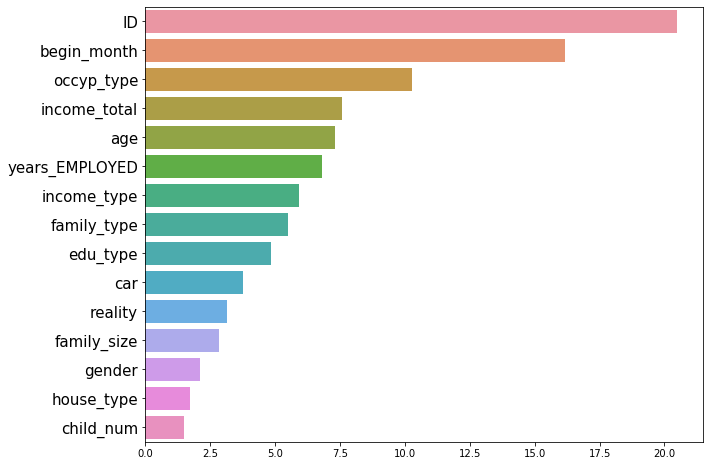

In [ ]:
enc = pipe.named_steps['ordinalencoder']
importances = pd.Series(model.feature_importances_, X_train.columns)
plt.figure(figsize=(10,8))
d = importances.sort_values(ascending=False)
sns.barplot(x=d.values, y=d.index);
plt.yticks(fontsize='15');

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

preprocessing = make_pipeline(
                     OrdinalEncoder()
                     )
X_train_proc = preprocessing.fit_transform(X_train)
X_val_proc = preprocessing.transform(X_val)

X_train_proc['begin_month'] = X_train_proc['begin_month'].astype('int64')
X_train_proc['family_size'] = X_train_proc['family_size'].astype('int64')
X_train_proc['income_total'] = X_train_proc['income_total'].astype('int64')

X_val_proc['begin_month'] = X_val_proc['begin_month'].astype('int64')
X_val_proc['family_size'] = X_val_proc['family_size'].astype('int64')
X_val_proc['income_total'] = X_val_proc['income_total'].astype('int64')

permuter = PermutationImportance(
    model,
    scoring='neg_log_loss', 
    n_iter=5,
    random_state=2
)

permuter.fit(X_val_proc, y_val);

In [ ]:
feature_names = X_val_proc.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)


Weight,Feature
0.1300 ± 0.0076,begin_month
0.0851 ± 0.0079,ID
0.0036 ± 0.0026,age
0.0015 ± 0.0018,income_total
0.0012 ± 0.0013,years_EMPLOYED
0.0002 ± 0.0010,family_size
0.0001 ± 0.0006,child_num
0 ± 0.0000,reality
0 ± 0.0000,occyp_type
0 ± 0.0000,income_type


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


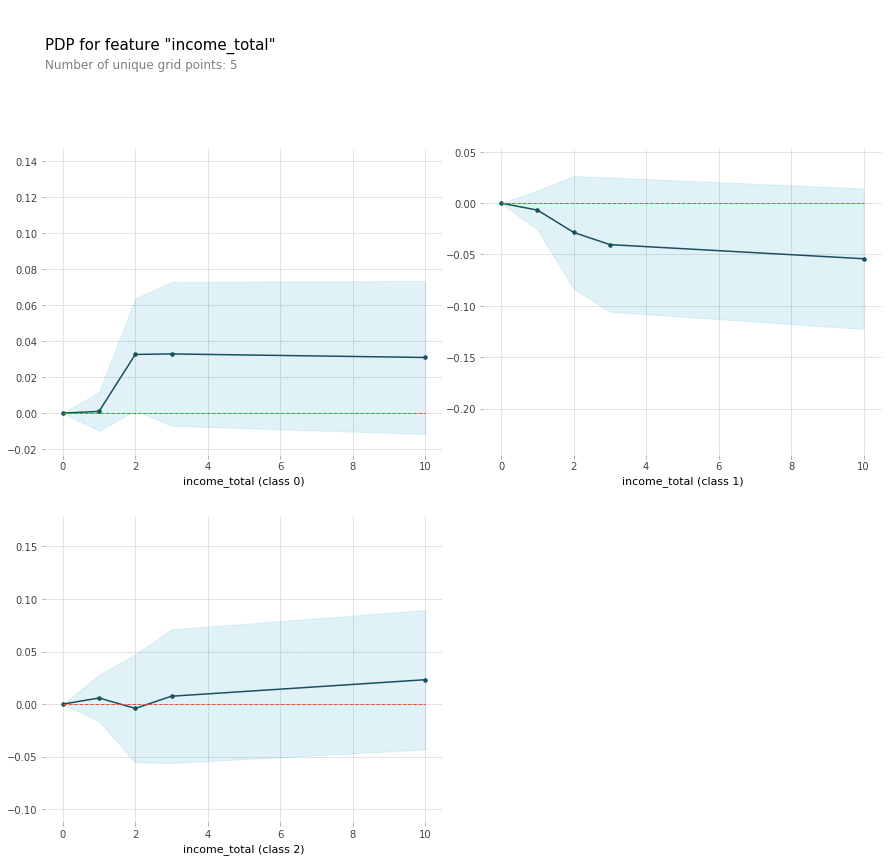

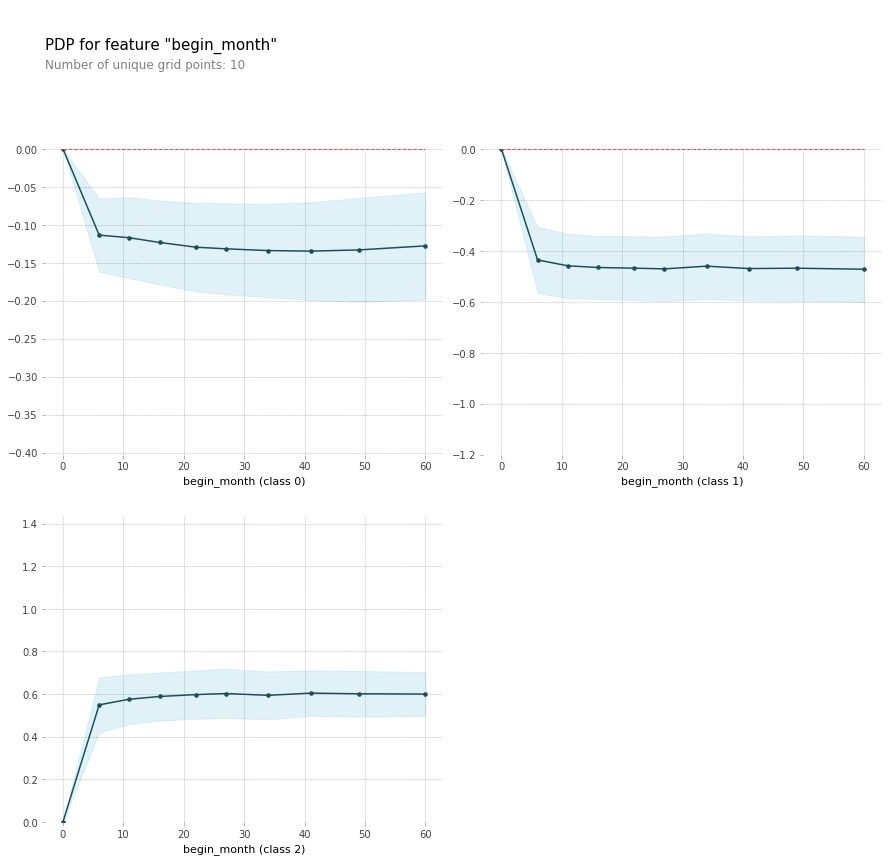

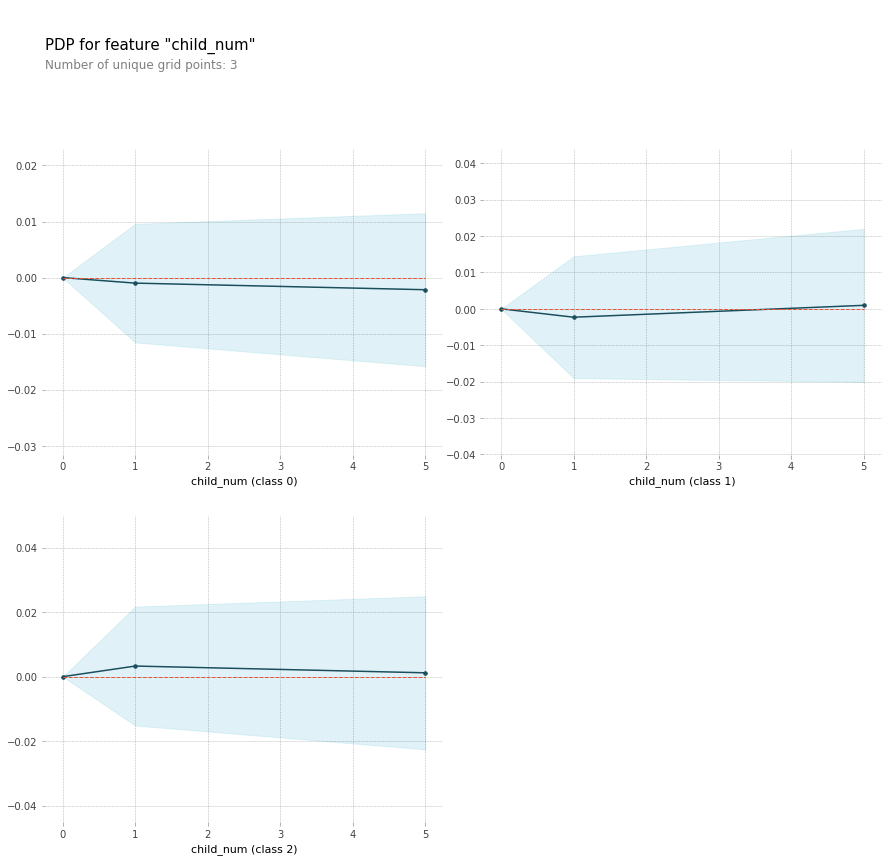

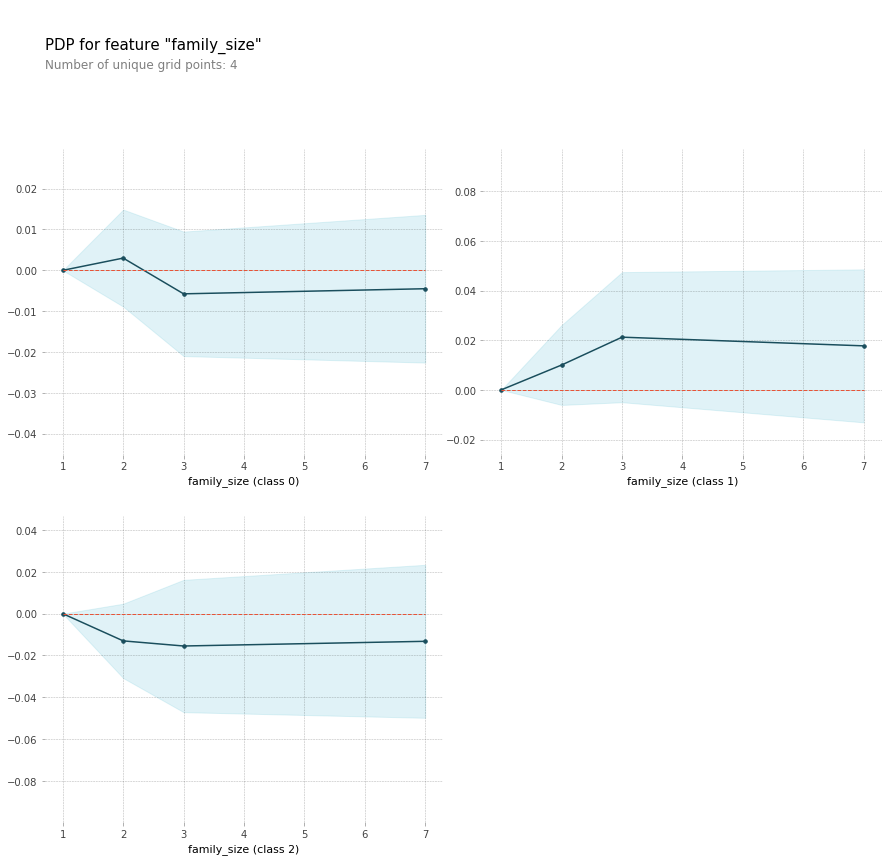

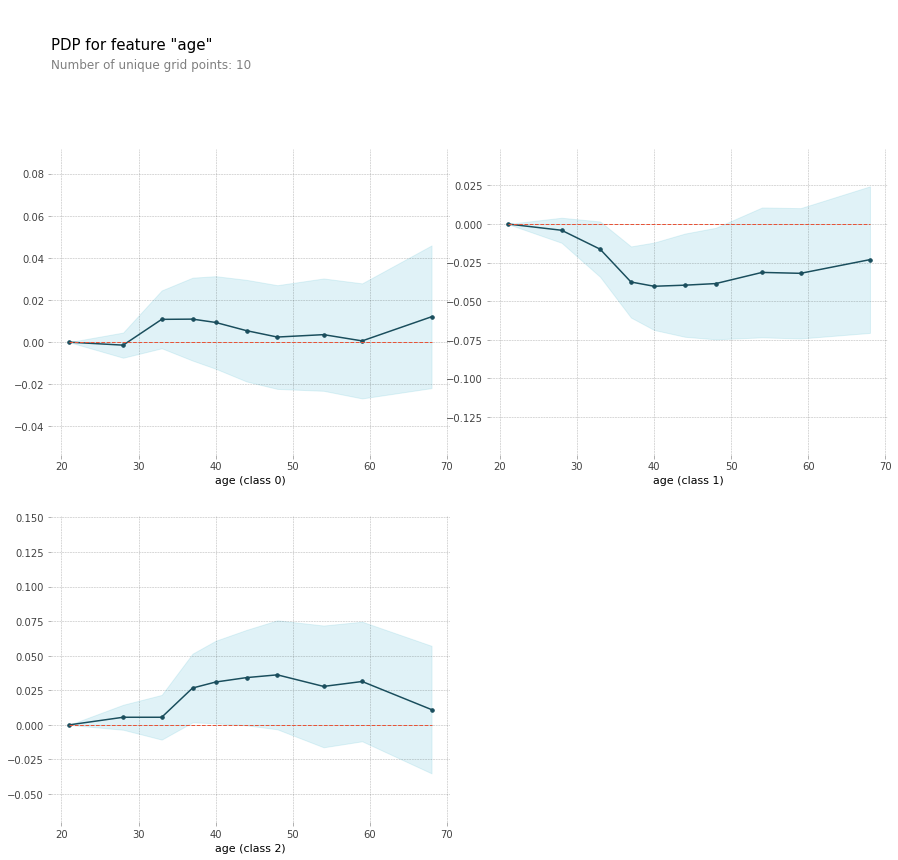

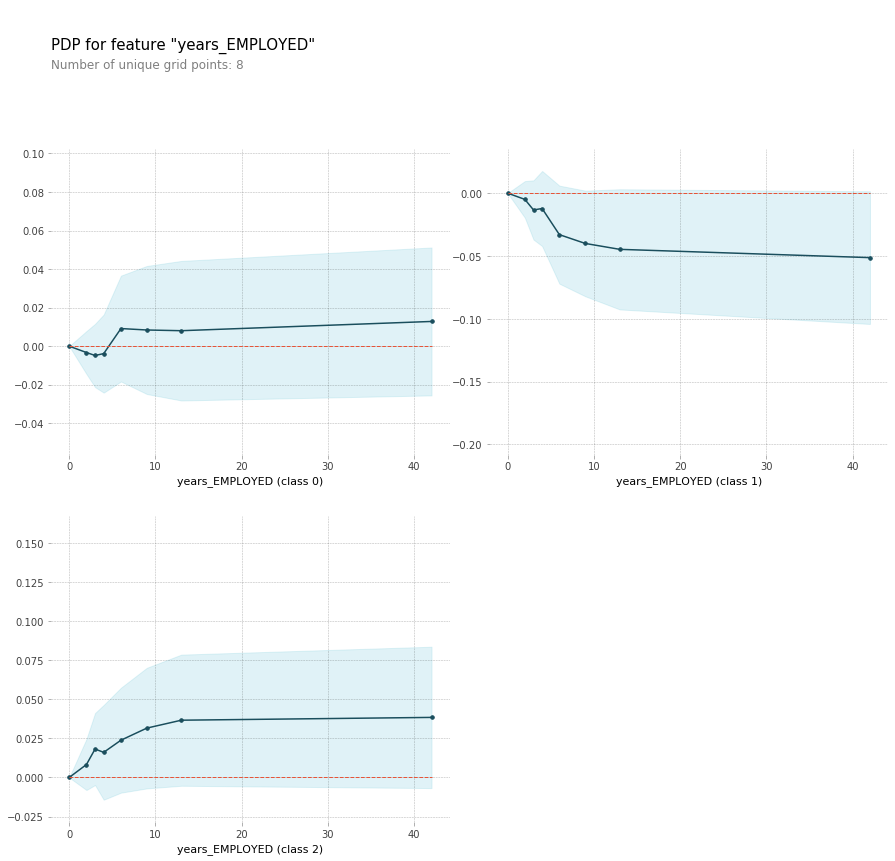

In [ ]:
# 수치형 데이터 그래프
from pdpbox.pdp import pdp_isolate, pdp_plot
'''
for i in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'income_total', 'begin_month', 
          'child_num', 'family_size', 'email', 'phone', 'work_phone',
          'age', 'baby', 'fwpe', 'years_EMPLOYED']:
          '''
for i in ['income_total', 'begin_month',
          'child_num', 'family_size',
          'age', 'years_EMPLOYED']:
    feature = i

    isolated = pdp_isolate(
        model=model, 
        dataset=X_val_proc, 
        model_features=X_val_proc.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature)
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


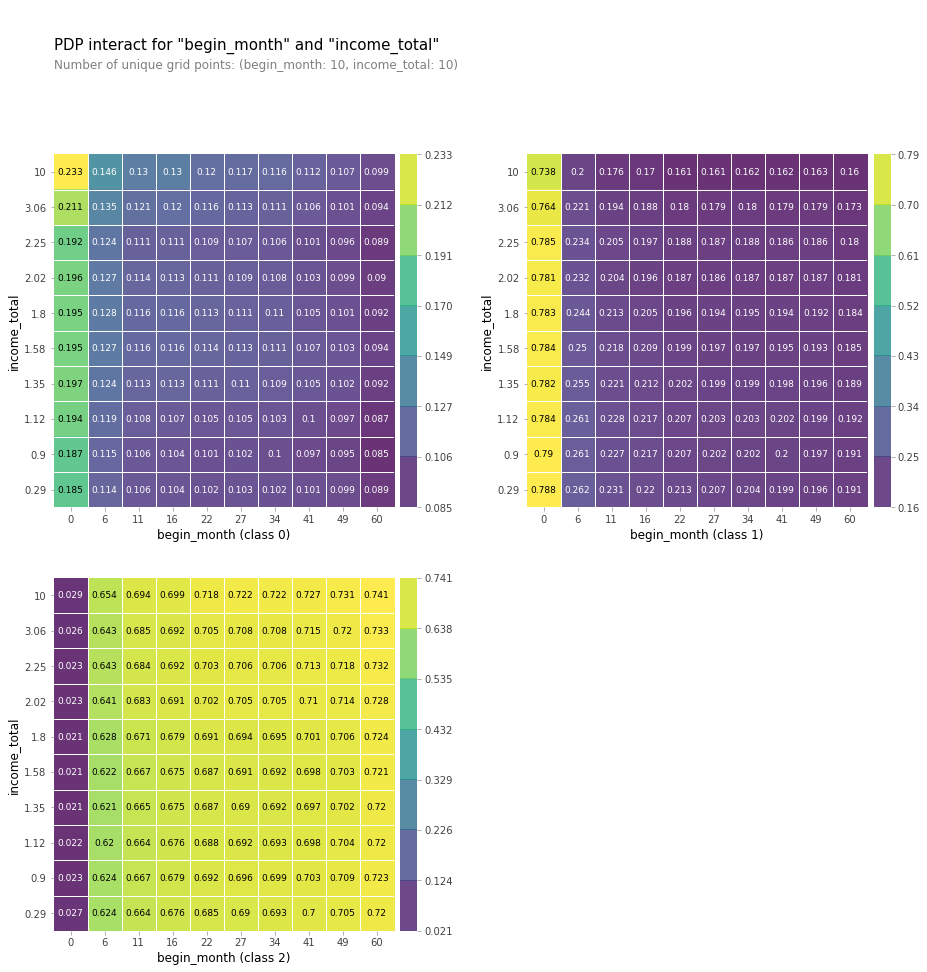

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['begin_month', 'income_total']

interaction = pdp_interact(
    model=model, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
minimum_importance = 0.02
mask = permuter.feature_importances_ > minimum_importance
# mask = permuter.feature_importances_ - permuter.feature_importances_std_ > 0
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

print('특성 삭제 전:', X_train.shape, X_val.shape)
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)


특성 삭제 전: (21165, 15) (5292, 15)
특성 삭제 후: (21165, 2) (5292, 2)


In [ ]:
# 0.02 이상 특성 선택
preprocessing = make_pipeline(
                     OrdinalEncoder(),
                     )
X_train_proc = preprocessing.fit_transform(X_train_selected)
X_val_proc = preprocessing.transform(X_val_selected)

#
train_dataset = Pool(data=X_train_proc,
                     label=y_train)

val_dataset = Pool(data=X_val_proc,
                  label=y_val)

# 모델 생성
model = CatBoostClassifier(iterations=3200,
                           learning_rate=0.011,
                           max_depth=10,
                           loss_function='MultiClass',
                           early_stopping_rounds = 100,
                           use_best_model = True,
                           verbose=100)

model.fit(train_dataset,
          eval_set=val_dataset)

# 모델 평가
preds_class = model.predict(val_dataset)
preds_proba = model.predict_proba(val_dataset)
preds_raw = model.predict(val_dataset, 
                          prediction_type='RawFormulaVal')

print(preds_raw)

print('accuracy :', accuracy_score(y_val, preds_class))
print('f1 score :', f1_score(y_val, preds_class, average='micro'))
print('log_loss :', log_loss(to_categorical(y_val['credit']), preds_proba))

print(classification_report(y_val, preds_class))


0:	learn: 1.0921974	test: 1.0920448	best: 1.0920448 (0)	total: 14.3ms	remaining: 45.6s
100:	learn: 0.8473245	test: 0.8397451	best: 0.8397451 (100)	total: 2.24s	remaining: 1m 8s
200:	learn: 0.8132899	test: 0.8051146	best: 0.8051146 (200)	total: 4.67s	remaining: 1m 9s
300:	learn: 0.8061043	test: 0.7992770	best: 0.7992770 (300)	total: 7.1s	remaining: 1m 8s
400:	learn: 0.8029456	test: 0.7979155	best: 0.7979155 (400)	total: 9.6s	remaining: 1m 7s
500:	learn: 0.8006902	test: 0.7975094	best: 0.7975094 (500)	total: 12.1s	remaining: 1m 5s
600:	learn: 0.7987242	test: 0.7974431	best: 0.7974323 (589)	total: 14.6s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7974322774
bestIteration = 589

Shrink model to first 590 iterations.
[[-1.00076334 -0.2659491   1.26671244]
 [-0.68230296 -0.4401212   1.12242417]
 [-0.76209873 -0.2256719   0.98777062]
 ...
 [-0.67917928 -0.34139346  1.02057275]
 [-0.76508319 -0.35215261  1.1172358 ]
 [-0.6514469  -0.32521096  0.9766578

In [ ]:
# 학습 그래프

results = model.evals_result_
train_error = results['learn']['MultiClass']
test_error = results['validation']['MultiClass']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

"\n# 학습 그래프\n\nresults = model.evals_result_\ntrain_error = results['learn']['MultiClass']\ntest_error = results['validation']['MultiClass']\n\nepoch = range(1, len(train_error)+1)\nplt.plot(epoch, train_error, label='Train')\nplt.plot(epoch, test_error, label='Test')\nplt.ylabel('Classification Error')\nplt.xlabel('Model Complexity (n_estimators)')\nplt.legend();\n"

In [ ]:
# Random Forest Classifier
'''
pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, criterion='entropy',
                           oob_score = True)
)

dists = {
    'randomforestclassifier__n_estimators' : range(10, 50),
    'randomforestclassifier__max_features' : np.arange(0.2, 0.8, 0.1),
    'randomforestclassifier__max_depth': range(5, 20),
    'randomforestclassifier__min_samples_leaf' : range(3, 30)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=500, 
    cv=3,
    scoring='f1_micro',
    verbose=10,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)

print('accuracy :', accuracy_score(y_val, y_pred))
print('f1 score :', f1_score(y_val, y_pred, average='micro'))
print('log_loss :', log_loss(to_categorical(y_val['credit']), y_pred_proba))

print(classification_report(y_val, y_pred))
'''

"\npipe = make_pipeline(\n    OrdinalEncoder(),\n    RandomForestClassifier(n_jobs=-1, criterion='entropy',\n                           oob_score = True)\n)\n\ndists = {\n    'randomforestclassifier__n_estimators' : range(10, 50),\n    'randomforestclassifier__max_features' : np.arange(0.2, 0.8, 0.1),\n    'randomforestclassifier__max_depth': range(5, 20),\n    'randomforestclassifier__min_samples_leaf' : range(3, 30)\n}\n\nclf = RandomizedSearchCV(\n    pipe, \n    param_distributions=dists, \n    n_iter=500, \n    cv=3,\n    scoring='f1_micro',\n    verbose=10,\n    n_jobs=-1\n)\n\nclf.fit(X_train, y_train)\n\ny_pred = clf.predict(X_val)\ny_pred_proba = clf.predict_proba(X_val)\n\nprint('accuracy :', accuracy_score(y_val, y_pred))\nprint('f1 score :', f1_score(y_val, y_pred, average='micro'))\nprint('log_loss :', log_loss(to_categorical(y_val['credit']), y_pred_proba))\n\nprint(classification_report(y_val, y_pred))\n"

In [ ]:
# print('최적 하이퍼파라미터: ', clf.best_params_)

In [ ]:
'''
'randomforestclassifier__n_estimators': 32, 'randomforestclassifier__min_samples_leaf': 3, 
'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_depth': 19}
accuracy : 0.7201436130007559
f1 score : 0.7201436130007558
log_loss : 0.7142589834694419
'''

"\n'randomforestclassifier__n_estimators': 32, 'randomforestclassifier__min_samples_leaf': 3, \n'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_depth': 19}\naccuracy : 0.7201436130007559\nf1 score : 0.7201436130007558\nlog_loss : 0.7142589834694419\n"

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, criterion='entropy',
                           oob_score = True)
)

dists = {
    'randomforestclassifier__n_estimators' : [32],
    'randomforestclassifier__max_features' : [0.2],
    'randomforestclassifier__max_depth': [19],
    'randomforestclassifier__min_samples_leaf' : [3]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=3,
    scoring='f1_micro',
    verbose=10,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)

print('accuracy :', accuracy_score(y_val, y_pred))
print('f1 score :', f1_score(y_val, y_pred, average='micro'))
print('log_loss :', log_loss(to_categorical(y_val['credit']), y_pred_proba))

print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


accuracy : 0.7125850340136054
f1 score : 0.7125850340136053
log_loss : 0.7300392215379518
              precision    recall  f1-score   support

         0.0       0.62      0.06      0.11       639
         1.0       0.71      0.31      0.43      1215
         2.0       0.71      0.98      0.82      3438

    accuracy                           0.71      5292
   macro avg       0.68      0.45      0.46      5292
weighted avg       0.70      0.71      0.65      5292



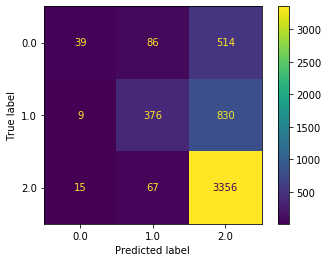

In [ ]:
plot_confusion_matrix(clf, X_val, y_val, values_format='d')

In [ ]:
### K-Means Clustering
oe = OrdinalEncoder()
X_train = oe.fit_transform(X_train)
X_val = oe.transform(X_val)
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train)
X_train['cluster'] = kmeans.predict(X_train)
X_val['cluster'] = kmeans.predict(X_val)


In [ ]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X_train, y_train):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X_train.shape[0], n_class))
cat_pred_test = np.zeros((X_val.shape[0], n_class))
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train_k = X_train.iloc[train_idx]
    X_valid_k = X_train.iloc[valid_idx]
    y_train_k = y_train.iloc[train_idx]
    y_valid_k = y_train.iloc[valid_idx]
    train_data = Pool(data=X_train_k, label=y_train_k)
    valid_data = Pool(data=X_valid_k, label=y_valid_k)

    model_cat = CatBoostClassifier(iterations=3500,
                                   learning_rate=0.01,
                                   max_depth=10,
                                   loss_function='MultiClass',
                                   l2_leaf_reg=0.001,
                                   use_best_model = True,
                                   early_stopping_rounds = 100,
                                   verbose=100,
                                   task_type='GPU')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, 
                  early_stopping_rounds=100, verbose=100)
  
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid_k)
    cat_pred_test += model_cat.predict_proba(X_val) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid_k, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y_train, cat_pred):.6f}')



----------------- Fold 0 -----------------

0:	learn: 1.0923491	test: 1.0925195	best: 1.0925195 (0)	total: 48.6ms	remaining: 2m 49s
100:	learn: 0.8145309	test: 0.8424512	best: 0.8424512 (100)	total: 2.72s	remaining: 1m 31s
200:	learn: 0.7393242	test: 0.7916339	best: 0.7916339 (200)	total: 5.21s	remaining: 1m 25s
300:	learn: 0.6964761	test: 0.7718234	best: 0.7718234 (300)	total: 7.69s	remaining: 1m 21s
400:	learn: 0.6581112	test: 0.7588555	best: 0.7588555 (400)	total: 10.2s	remaining: 1m 18s
500:	learn: 0.6238611	test: 0.7482907	best: 0.7482907 (500)	total: 12.7s	remaining: 1m 16s
600:	learn: 0.5948182	test: 0.7391351	best: 0.7391351 (600)	total: 15.2s	remaining: 1m 13s
700:	learn: 0.5690843	test: 0.7323452	best: 0.7323452 (700)	total: 17.7s	remaining: 1m 10s
800:	learn: 0.5437525	test: 0.7267230	best: 0.7267230 (800)	total: 20.2s	remaining: 1m 8s
900:	learn: 0.5197608	test: 0.7218429	best: 0.7218429 (900)	total: 22.7s	remaining: 1m 5s
1000:	learn: 0.4998061	test: 0.7183099	best: 0.718

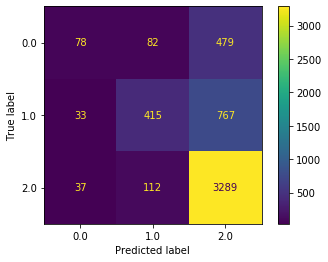

In [ ]:
plot_confusion_matrix(model_cat, X_val, y_val, values_format='d')